# Train an ML Model Using Sklearn
___

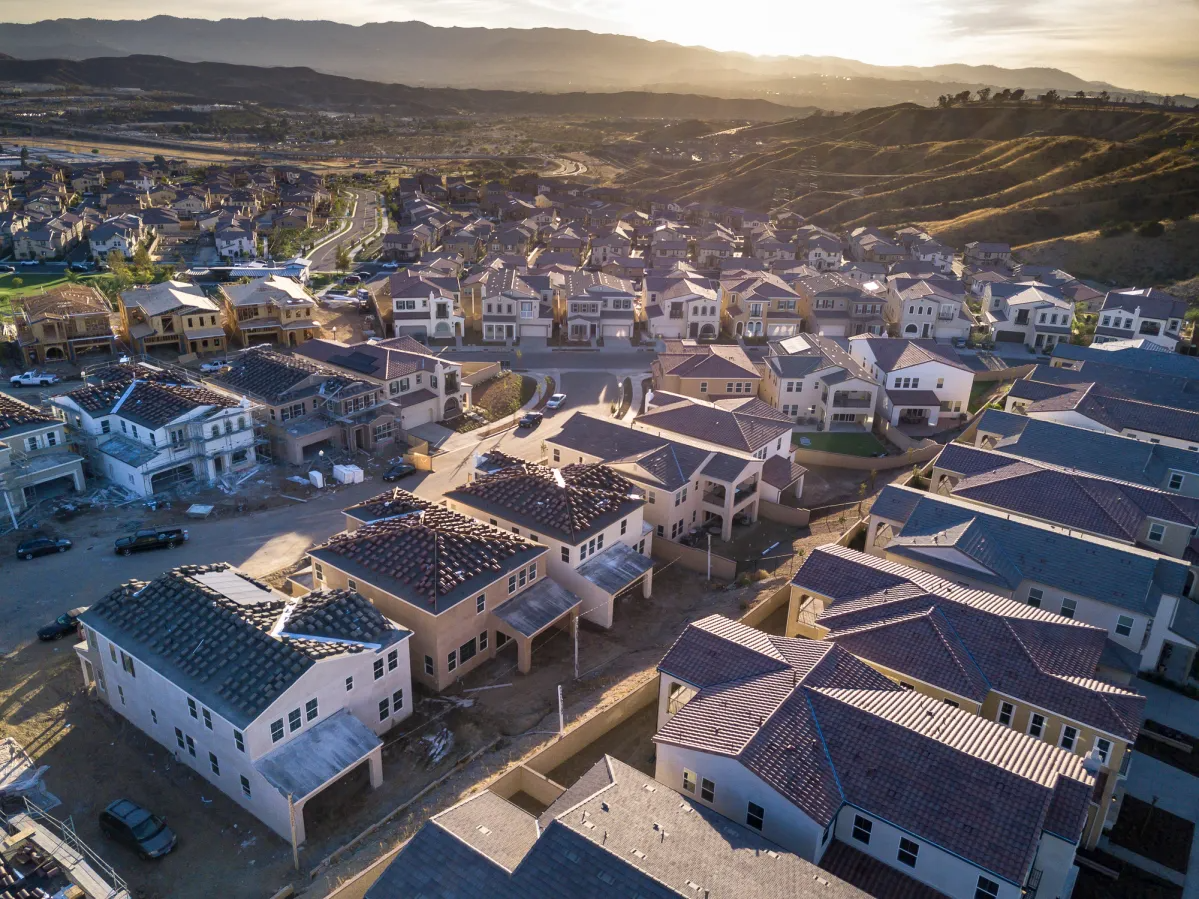
## What We will be Doing
- using california housing dataset
- experimenting with different ml regression models
- creating visuals
- create a stacking regressor
- fine tune models
- save & load models

# Import Packages and Dataset

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [2]:
# load the data
cali_data = fetch_california_housing(as_frame=True)
cali_df = cali_data.frame

# drop the latitude and longitude features
cali_df.drop(columns=['Latitude', 'Longitude'], inplace=True)

# show some examples and the number of observations
print(f"Number of observations: {len(cali_df)}")
cali_df.head()

Number of observations: 20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,3.422


# Data Overview
___

## Target Variable | Dependent Variable
- Median House Value

## Features | Independent Variable
- Median Income
- House Age
- Average Rooms
- Aveerage Bedrooms
- Popuation
- Average Occupation

**See below for an Exhaustive Explanation of what is in this dataset and where it comes from.**

In [3]:
print(cali_data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

# Create Scatter Matrix to Get an Idea of what is Correlated with Median House Value
___

As you can see from the visual below it looks like the most correlated with median house value is median income. This could be true or it could actually be the other way around with reverse causality where the median house value is determining the median income.

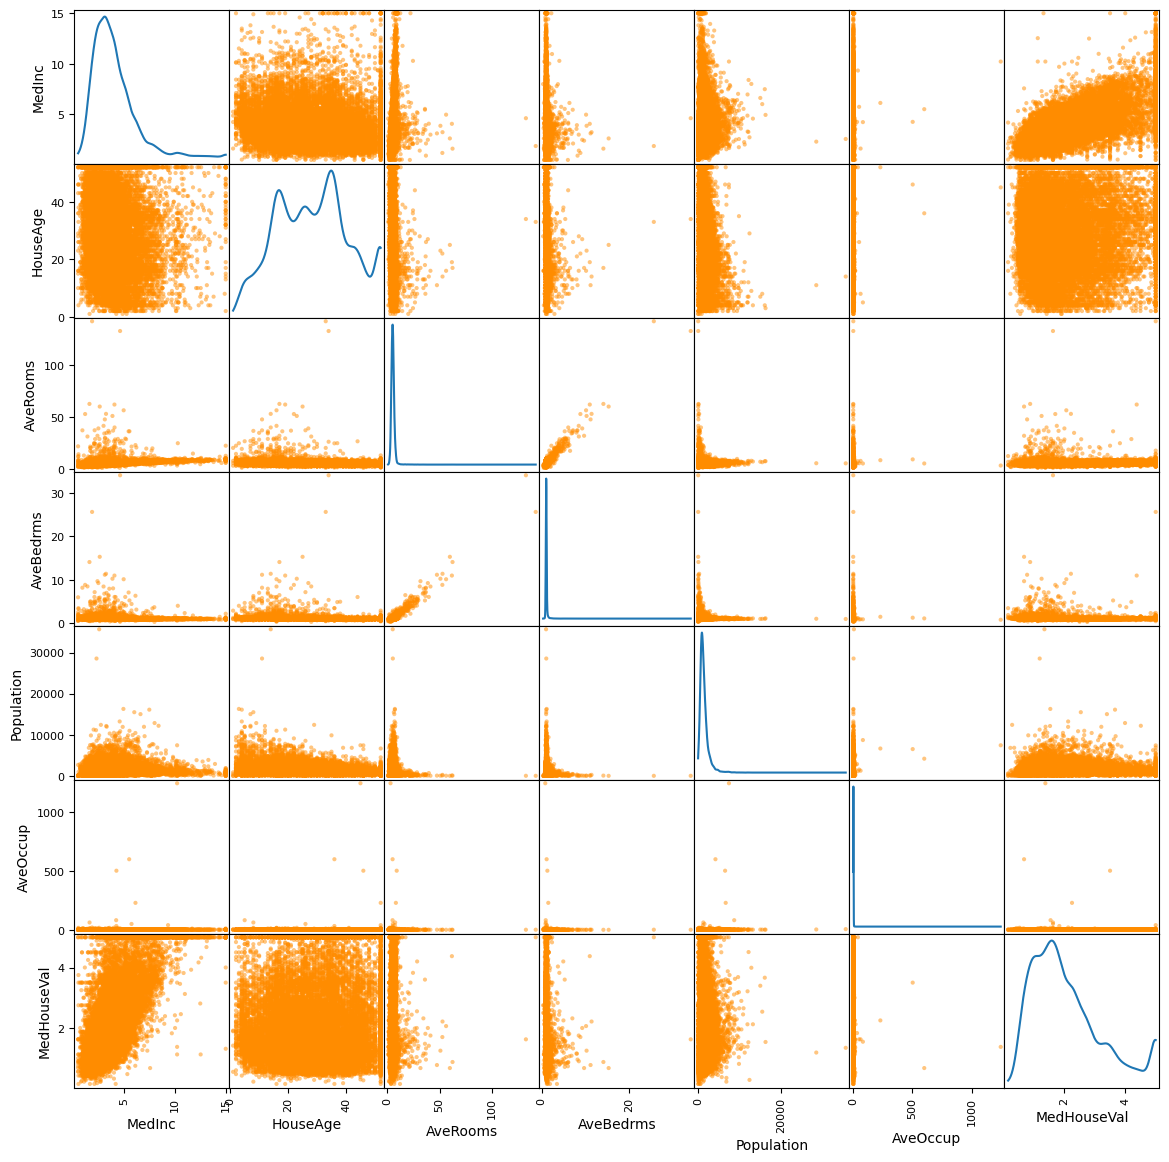

In [4]:
pd.plotting.scatter_matrix(cali_df, figsize=(14,14), color='darkorange', diagonal='kde')
plt.show()

# See what Our Results are Like from a Simple OLS Regression

1) Standardize our input features giving it a mean of zero and unit variance - standard deviation of 1
2) Spilt the data into training and testing sets applying a 75/25 train test split
3) Create the regression model
4) Train model and Predict on test set
5) Calculate regression performance metrics

**NOTE:
One thing to note is that each time we run this cell the metrics will be different. This is because each time we are doing a different training and testing split since we did not set a random state variable**

In [5]:
# Section off the input features from the target variable
X = cali_df.iloc[:, :6]
y = cali_df.iloc[:, -1:]

# Standardize the input features
X_scaled = StandardScaler().fit_transform(X)

# Create the train test set split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

# Instantiate the model
ols = LinearRegression()

# Train the regression model and create a prediction base on the testing data
ols.fit(X_train, y_train)
ols_prediction = ols.predict(X_test)

# Get Regression performance metrics
ols_r2_score = r2_score(y_test, ols_prediction)
ols_mse = mean_squared_error(y_test, ols_prediction)

# Show metrics
border ='-'*40
print(f"Base OLS Regression:")
print(border)
print(f"R2 Score: {ols_r2_score}")
print(f"MSE Score: {ols_mse}")

Base OLS Regression:
----------------------------------------
R2 Score: 0.5231996927803989
MSE Score: 0.6254744987288912


# Create a Function so we can do this at a Larger Scale for Different Regression Models
___

This will be for the base models with no fine tuning of the parameters

In [6]:
def train_predict(model:any, name:str, X:np.array, y:np.array) -> list:
    """
    Trains the sklearn model and returns a list that can be used for viuals and validation.

    Parameters
    ----------
    model : any
        Sklearn model to train 
    name : str
        Name of the sklearn model
    X : np.array
        Input features 
    y : np.array
        Target variable

    Returns
    -------
    list
        List of the name and metrics to be added to a larger dataframe.
    """

    # Standardize input features
    X_scaled = StandardScaler().fit_transform(X)
                                              
    # Create the train test set split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)
    
    # train model
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    # Get metrics
    r2 = round(r2_score(y_test, prediction),3)
    mse = round(mean_squared_error(y_test, prediction),3)

    # return the name and the metrics as a list
    return [i for i in [name, r2, mse]]

def section_scale_split(cali_dataframe:pd.DataFrame) -> tuple:
    """
    Sections of the dependent features and independent features in california
    housing dataset. Sends back a scaled version of the input features that 
    are split into a training and test set.

    Parameters
    ----------
    cali_dataframe : pd.DataFrame
        California housing dataframe

    Returns
    -------
    tuple
        X_train, X_test, y_train, y_test
    """

    # Section off the input features from the target variable
    X = cali_data.data
    y = cali_data.target

    # Standardize the input features
    X_scaled = StandardScaler().fit_transform(X)

    # Create training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)
    
    return (X_train, X_test, y_train, y_test)

# Check to see which Base Models Perform the Best
___

- train and predict getting metrics
- put them into a dataframe
- visualize results

In [7]:
X = cali_df.iloc[:, :6]
y = np.array(cali_df.iloc[:, -1]).ravel()

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          RandomForestRegressor(),
          DecisionTreeRegressor(),
          SVR(), 
          GradientBoostingRegressor(),
          AdaBoostRegressor(),
          xgb.XGBRegressor()]

model_names = ['OLS',
               'Ridge',
               'Lasso',
               'ElasticNet',
               'Random Forest',
               'Decision Tree',
               'SVR',
               'GBR',
               'Ada Boost',
               'XGB']

results = []
loop = tqdm(total=len(models), colour='green')
for model, name in zip(models, model_names):
    metrics = train_predict(model, name, X, y)
    results.append(metrics)
    loop.set_description(f"Model: {name} | R2: {metrics[1]} | MSE: {metrics[2]}")
    loop.update(1)

dataframe_results = pd.DataFrame(data=results,
                                 columns=['Model Name',
                                          'R Squared',
                                          'MSE'])

dataframe_results

Model: XGB | R2: 0.669 | MSE: 0.44: 100%|██████████| 10/10 [00:19<00:00,  1.64s/it]          

,Model Name,R Squared,MSE
0,OLS,0.557,0.584
1,Ridge,0.522,0.632
2,Lasso,-0.000,1.324
3,ElasticNet,0.207,1.045
4,Random Forest,0.693,0.411
5,Decision Tree,0.368,0.833
6,SVR,0.669,0.421
7,GBR,0.672,0.425
8,Ada Boost,0.476,0.694
9,XGB,0.669,0.440


# Visualize the Results
___

We will want to choose the top three models that perform the best so that we can put them into a regression stacking model.

This means we are looking for the model with the highest R Squared and the lowest Mean Squared Error.

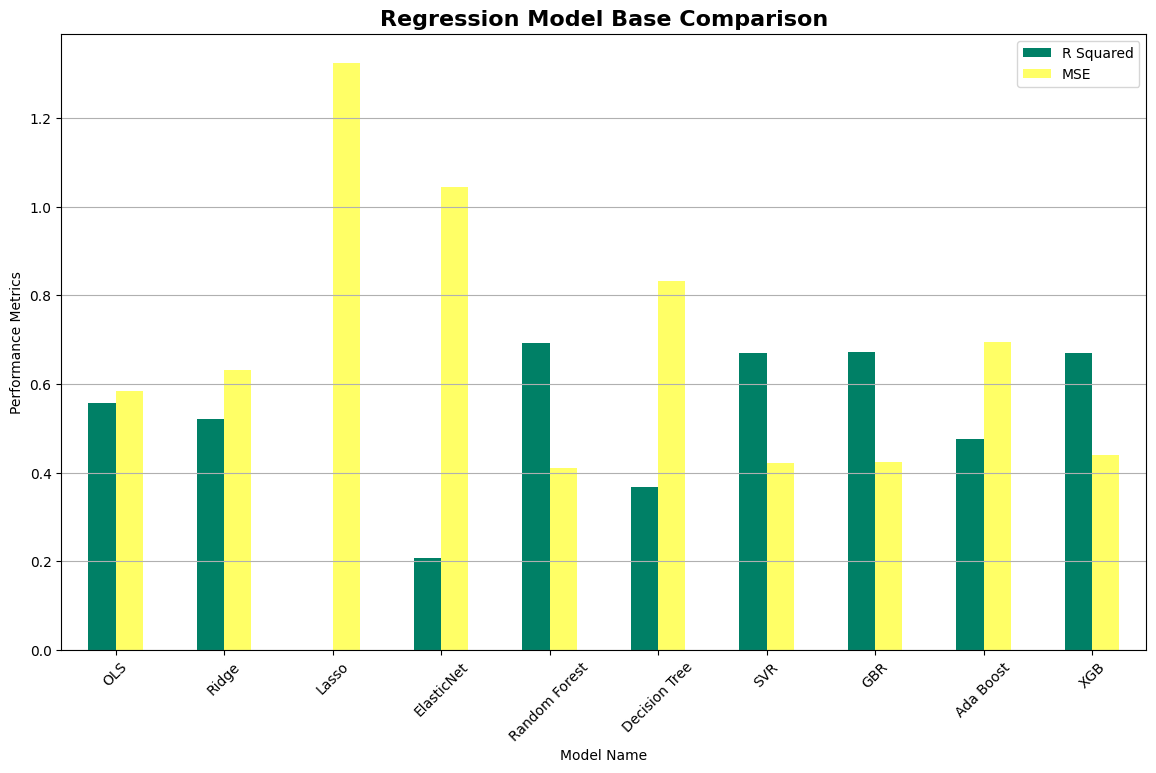

In [8]:
dataframe_results.plot(kind='bar', figsize=(14,8), colormap='summer', x='Model Name')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.ylabel("Performance Metrics")
plt.title("Regression Model Base Comparison", fontweight='bold', fontsize=16)
plt.show()

# Fine Tune The Top Three Performing Models
1) XGBoost
2) Random Forest
3) GBR

**We will do this using gridsearch cross validation function in sklearn**

Explanation:
___

Whats happening here is we are iterating through each possible combination of the provided parameters and finding which combination will get us the best results based on the data we provide. This is also then going to be cross validated based on the "cv=5" parameter - this is using the default 5 fold cross validation. "n_jobs=-1" it saying that we want to leverage all the available cpu cores on our machine to process this.

Sklearn Documentation on GridsearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# XGBoost Fine Tuning (Extreme Gradient Boosting)

Documentation for model parameters can be found at the link below:

https://xgboost.readthedocs.io/en/stable/parameter.html

In [9]:
X = cali_df.iloc[:, :6]
y = np.array(cali_df.iloc[:, -1]).ravel()

# Create a new xgb model
xgb_model = xgb.XGBRegressor()

# Create the dictionary of values to test for
xgb_params = {'learning_rate': [0.001, 0.01, 0.1, 0.25, 0.5],
              'min_split_loss': [0.001, 0.01, 0.1, 0.25, 0.5],
              'max_depth': [3, 4, 5, 6, 7],
              'reg_alpha': [0.001, 0.01, 0.1, 0.25, 0.5]}

# Create the gridsearch object using 5 fold cross validation
xgb_gridsearch = GridSearchCV(xgb_model,
                          xgb_params,
                          cv=5,
                          n_jobs=-1)

xgb_gridsearch.fit(X, y)

best_xgb_params = xgb_gridsearch.best_params_
best_xgb_score = xgb_gridsearch.best_score_

In [10]:
def display_results(model_name:str, params:dict, best_params:dict, best_score:float) -> None:
    """
    Displays the results from the gridsearch cv.

    Parameters
    ----------
    params : dict
        Input params that were tested
    best_params : dict
        Best params from the input params
    best_score : float
        Best score from the best params
    """

    # show the results 
    print(f"{model_name} Model Results")
    print(border)
    print(f"{model_name} Model Best Params:")
    for i in params.keys():
        print(f"{i}: {best_params[i]}")
    print(f"{model_name} Model Best Score: {best_score}")
    print(border)

In [11]:
display_results('XGBoost', xgb_params, best_xgb_params, best_xgb_score)

XGBoost Model Results
----------------------------------------
XGBoost Model Best Params:
learning_rate: 0.1
min_split_loss: 0.25
max_depth: 5
reg_alpha: 0.001
XGBoost Model Best Score: 0.6439798334182388
----------------------------------------


## Overview:

Now that we have a general idea of what the best parameters are (they are stored in the best_xgb_params) we can move on ahead to the next regression model. One thing to note here is that these are probably not the best best parameters but they are better than the base model. Going further into model fine tuning would take much more time.

# Random Forest Model Fine Tuning

Sklearn Random Forest Regressor Documentation:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

**This may take a while to run since we are not setting a max depth**

In [12]:
X = cali_df.iloc[:, :6]
y = np.array(cali_df.iloc[:, -1]).ravel()

# Create a new xgb model
rf_model = RandomForestRegressor()

# Create the dictionary of values to test for
rf_params = {'n_estimators': [50, 75, 100, 125, 150],
              'ccp_alpha': [0.0001, 0.001, 0.01, 0.1, 0.25]}

# Create the gridsearch object using 5 fold cross validation
rf_gridsearch = GridSearchCV(rf_model,
                          rf_params,
                          cv=5,
                          n_jobs=-1)

rf_gridsearch.fit(X, y)

best_rf_params = rf_gridsearch.best_params_
best_rf_score = rf_gridsearch.best_score_

In [13]:
display_results("Random Forest", rf_params, best_rf_params, best_rf_score)

Random Forest Model Results
----------------------------------------
Random Forest Model Best Params:
n_estimators: 150
ccp_alpha: 0.0001
Random Forest Model Best Score: 0.632346866534826
----------------------------------------


# Gradient Boosting Regressor (GBR) Fine Tuning

Sklearn documnetation:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [14]:
X = cali_df.iloc[:, :6]
y = np.array(cali_df.iloc[:, -1]).ravel()

# Create a new xgb model
gbr_model = GradientBoostingRegressor()

# Create the dictionary of values to test for
gbr_params = {'n_estimators': [50, 75, 100, 125, 150],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
              'max_depth': [None, 2, 3, 4, 5]}

# Create the gridsearch object using 5 fold cross validation
gbr_gridsearch = GridSearchCV(gbr_model,
                          gbr_params,
                          cv=5,
                          n_jobs=-1)

gbr_gridsearch.fit(X, y)

best_gbr_params = gbr_gridsearch.best_params_
best_gbr_score = gbr_gridsearch.best_score_

In [15]:
display_results("Gradient Boosted Regressor", gbr_params, best_gbr_params, best_gbr_score)

Gradient Boosted Regressor Model Results
----------------------------------------
Gradient Boosted Regressor Model Best Params:
n_estimators: 100
learning_rate: 0.1
max_depth: 5
Gradient Boosted Regressor Model Best Score: 0.6422059463340173
----------------------------------------


# Stacking Regressor
___

Here we will now take the three models that we have fine tuned and create a stacking regressor out of them.

Sklearn Stacking Regressor Documentation: 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

In [21]:
# Create the three models with the best parameters
xgb_best = xgb.XGBRegressor(learning_rate=0.1,
                            min_split_loss=0.25,
                            max_depth=5,
                            reg_alpha=0.001)

rf_best = RandomForestRegressor(n_estimators=150,
                                ccp_alpha=0.0001)

gbr_best = GradientBoostingRegressor(n_estimators=150,
                                     learning_rate=0.2,
                                     max_depth=3)

In [22]:
# Create Stacking Regressor
stack = StackingRegressor(estimators=[('xgb', xgb_best),
                                      ('rf', rf_best),
                                      ('gbr', gbr_best)],
                         final_estimator=LinearRegression())

# See how well it does
stack_metrics = train_predict(stack, 'Stacking Regressor', X, y)
print(stack_metrics)

['Stacking Regressor', 0.696, 0.411]


# Test with Cross Validation

In [23]:
cv_results = cross_validate(stack,
                            X,
                            y,
                            cv=5,
                            n_jobs=-1)
cv_results

{'fit_time': array([251.31028581, 255.57543468, 256.52178311, 254.97592473,
        255.87583399]),
 'score_time': array([0.08304548, 0.08375859, 0.08290792, 0.09906554, 0.06714416]),
 'test_score': array([0.63991398, 0.64428019, 0.70222873, 0.5811952 , 0.66715829])}

# Save the Model to a Pickle File

In [24]:
# Create a models directory
import os

if not os.path.exists('models'):
    os.mkdir('models')

In [25]:
# Save the model
with open('models/ca_housing_prices.pkl', 'wb') as f:
    pickle.dump(stack, f)